In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_folder = "/content/drive/MyDrive/Photo/Dataset/New dataset"

Mounted at /content/drive


In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_intrinsics(path):
    """
    Reads a 3x3 K matrix from K.txt of the form:
    K = [fx 0 cx;
         0 fy cy;
         0 0 1]
    """
    h, w = path.shape[:2]
    fx = fy = float(w)
    cx = w / 2.0
    cy = h / 2.0

    K = np.array([
        [fx,  0,  cx],
        [ 0, fy, cy],
        [ 0,  0,  1 ]
    ], dtype=np.float64)

    print("Computed Intrinsics:")
    print(K)
    return K


def feature_extractor():
    # use sift, and fall back to ORB if not available
    if hasattr(cv2, 'SIFT_create'):
        return cv2.SIFT_create(), 'SIFT'
    else:
        return cv2.ORB_create(5000), 'ORB'


def detect_and_describe(image, detector):
    # return keypoints and descriptors for an image.
    keypoints, descriptors = detector.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = np.zeros((0, 128), dtype=np.float32)
    return keypoints, descriptors


def match_features(desc1, desc2, method='L2', ratio=0.75):
    # knn and lowe ratio test
    # L2 for sift, and hamming for ORB
    if desc1 is None or desc2 is None or len(desc1) == 0 or len(desc2) == 0:
        return []

    if method == 'L2':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    else:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    knn_matches = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good


def triangulate_points(P0, P1, pts0, pts1, R0, t0, R1, t1):
    """
    triangulate points and apply cheirality check
    dimensions:- pts0, pts1: (N,2)
    R0, t0, R1, t1: camera extrinsics(world to cam frame)
    """
    pts0_h = pts0.T
    pts1_h = pts1.T

    pts4d = cv2.triangulatePoints(P0, P1, pts0_h, pts1_h)  #(4,N)
    pts3d = (pts4d[:3] / pts4d[3]).T  #(N,3)

    #cheirality check: z > 0 in both camera frames
    #camera 0 is world frame here X_cam0 = X_world
    X_cam0 = pts3d
    X_cam1 = (R1 @ pts3d.T + t1).T

    mask = (X_cam0[:, 2] > 0) & (X_cam1[:, 2] > 0)
    return pts3d[mask], mask


def extract_colors(img, pts2d):
    h, w = img.shape[:2]
    colors = []
    for x, y in pts2d:
        xi = int(round(x))
        yi = int(round(y))
        if 0 <= xi < w and 0 <= yi < h:
            colors.append(img[yi, xi])
        else:
            colors.append([0, 0, 0])
    return np.array(colors, dtype=np.uint8)


def save_point_cloud(points, colors, filename="output_with_colors.ply"):
    assert points.shape[0] == colors.shape[0]
    N = points.shape[0]
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {N}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {int(c[2])} {int(c[1])} {int(c[0])}\n")


def display_pcd(points, step=5):
    if points.shape[0] > 5000:
        pts = points[::step]
    else:
        pts = points

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Sparse Point Cloud")
    plt.show()

def incremental_sfm(data_dir="/content/drive/MyDrive/Photo/Dataset/New dataset"):
    image_paths = sorted(glob.glob(os.path.join(data_dir, "*.JPG")))
    assert len(image_paths) >= 2, "Need at least two images."

     # image size from the first image
    first_image = cv2.imread(image_paths[3])
    height, width = first_image.shape[:2]

    # Construct the intrinsic matrix K
    fx = width  # Approximate focal length as image width
    fy = height  # Approximate focal length as image height
    cx = width / 2  # Principal point x (image center)
    cy = height / 2  # Principal point y (image center)

    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0, 0, 1]], dtype=np.float64)

    print("Intrinsic K:\n", K)

    images_color = [cv2.imread(p) for p in image_paths]
    images_gray  = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images_color]

    # extract features across all images
    detector, detector_name = feature_extractor()
    print("Using feature detector:", detector_name)

    keypoints_list = []
    descriptors_list = []
    for i, img in enumerate(images_gray):
        kp, des = detect_and_describe(img, detector)
        keypoints_list.append(kp)
        descriptors_list.append(des)
        print(f"Image {i}: {len(kp)} keypoints.")

    # an array mapping kp index in the image to a 3D point index and -1 if not assigned
    kp_to_3d_idx = [np.full(len(kp), -1, dtype=int) for kp in keypoints_list]

    print("\n=== Initialization: images 0 & 1 ===")
    method = 'L2' if detector_name == 'SIFT' else 'HAMMING'
    matches01 = match_features(descriptors_list[0], descriptors_list[1], method=method)

    if len(matches01) < 20:
        raise RuntimeError("Not enough matches between first two images for initialization.")

    pts0 = np.float32([keypoints_list[0][m.queryIdx].pt for m in matches01])
    pts1 = np.float32([keypoints_list[1][m.trainIdx].pt for m in matches01])

    # essential mat
    E, mask_E = cv2.findEssentialMat(pts0, pts1, K, method=cv2.RANSAC,
                                     prob=0.999, threshold=1.0)
    mask_E = mask_E.ravel().astype(bool)
    pts0_inliers = pts0[mask_E]
    pts1_inliers = pts1[mask_E]
    matches_inliers = [m for m, keep in zip(matches01, mask_E) if keep]

    print(f"Inliers after EssentialMat: {len(pts0_inliers)}")

    # recover pose [R|t] (camera 0 at I|0, camera 1 at R|t)
    _, R1, t1, mask_pose = cv2.recoverPose(E, pts0_inliers, pts1_inliers, K)
    mask_pose = mask_pose.ravel().astype(bool)
    pts0_inliers = pts0_inliers[mask_pose]
    pts1_inliers = pts1_inliers[mask_pose]

    print(f"Inliers after recoverPose: {len(pts0_inliers)}")

    # final inlier matches for mapping kp indices
    final_matches = [m for m, keep in zip(matches_inliers, mask_pose) if keep]
    # projection matrxes
    R0 = np.eye(3)
    t0 = np.zeros((3, 1))
    P0 = K @ np.hstack([R0, t0])
    P1 = K @ np.hstack([R1, t1])

    pts3d_init, mask_ch = triangulate_points(
        P0, P1, pts0_inliers, pts1_inliers, R0, t0, R1, t1
    )
    print("Triangulated initial 3D points:", pts3d_init.shape[0])

    valid_match_indices = np.where(mask_ch)[0]

    map_points_3d = []
    map_colors = []

    for local_idx_3d, match_idx in enumerate(valid_match_indices):
        m = final_matches[match_idx]
        kp_idx0 = m.queryIdx
        kp_idx1 = m.trainIdx

        # pts3d_init is already filtered by mask_ch, so local_idx_3d indexes it
        X = pts3d_init[local_idx_3d]
        map_points_3d.append(X)

        color = extract_colors(
            images_color[0],
            [keypoints_list[0][kp_idx0].pt]
        )[0]
        map_colors.append(color)

        #map all keypoints to  global 3D point index
        global_idx = local_idx_3d
        kp_to_3d_idx[0][kp_idx0] = global_idx
        kp_to_3d_idx[1][kp_idx1] = global_idx

    map_points_3d = np.array(map_points_3d, dtype=np.float64)
    map_colors = np.array(map_colors, dtype=np.uint8)

    print("Initial map points:", map_points_3d.shape[0])
    camera_R = [R0, R1]
    camera_t = [t0, t1]

    #incremental PnP
    localized_indices = [0, 1]
    last_good = 1

    for i in range(2, len(images_gray)):
        print(f"\n=== Adding image {i} ===")

        pts2d = []
        pts3d = []
        used_kp_curr = set()

        total_matches_used = 0

        for j in localized_indices:
            matches_ji = match_features(descriptors_list[j], descriptors_list[i], method=method)
            if len(matches_ji) == 0:
                continue

            for m in matches_ji:
                kp_prev_idx = m.queryIdx
                kp_curr_idx = m.trainIdx

                if kp_curr_idx in used_kp_curr:
                    continue

                mp_idx = kp_to_3d_idx[j][kp_prev_idx]
                if mp_idx >= 0:
                    pts3d.append(map_points_3d[mp_idx])
                    pts2d.append(keypoints_list[i][kp_curr_idx].pt)
                    used_kp_curr.add(kp_curr_idx)
                    total_matches_used += 1

        pts3d = np.array(pts3d, dtype=np.float32)
        pts2d = np.array(pts2d, dtype=np.float32)

        print("Total 2D-3D correspondences for PnP (from all previous cameras):",
              pts3d.shape[0])

        if pts3d.shape[0] < 20:
            print("Not enough 2D-3D points for PnP, skipping this image.")
            camera_R.append(camera_R[-1])
            camera_t.append(camera_t[-1])
            continue

        #pnp with ransac
        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            pts3d, pts2d, K, None,
            flags=cv2.SOLVEPNP_ITERATIVE,
            reprojectionError=10.0,
            confidence=0.999,
            iterationsCount=500
        )

        if not success:
            print("PnP failed, skipping this image.")
            camera_R.append(camera_R[-1])
            camera_t.append(camera_t[-1])
            continue

        inliers = inliers.ravel()
        print("PnP inliers:", len(inliers))

        R_i, _ = cv2.Rodrigues(rvec)
        t_i = tvec.reshape(3, 1)

        camera_R.append(R_i)
        camera_t.append(t_i)

        last_good = i
        localized_indices.append(i)

        # triangulate new points using an anchor camera
        prev = last_good - 1
        if prev < 0:
            prev = 0

        matches = match_features(descriptors_list[prev], descriptors_list[i], method=method)
        print(f"Matches anchor({prev})-curr({i}):", len(matches))

        P_prev = K @ np.hstack([camera_R[prev], camera_t[prev]])
        P_curr = K @ np.hstack([R_i, t_i])

        new_pts3d = []
        new_colors = []
        new_kp_curr_indices = []

        for m in matches:
            kp_prev_idx = m.queryIdx
            kp_curr_idx = m.trainIdx

            if kp_to_3d_idx[prev][kp_prev_idx] >= 0:
                continue
            if kp_to_3d_idx[i][kp_curr_idx] >= 0:
                continue

            pt_prev = np.float32(keypoints_list[prev][kp_prev_idx].pt)
            pt_curr = np.float32(keypoints_list[i][kp_curr_idx].pt)

            pts0 = np.array([pt_prev], dtype=np.float32)
            pts1 = np.array([pt_curr], dtype=np.float32)

            pts3d_pair, mask_ch = triangulate_points(
                P_prev, P_curr, pts0, pts1,
                camera_R[prev], camera_t[prev],
                R_i, t_i
            )

            if pts3d_pair.shape[0] == 0:
                continue

            X = pts3d_pair[0]
            new_pts3d.append(X)
            new_kp_curr_indices.append((kp_prev_idx, kp_curr_idx))

            color = extract_colors(images_color[i], [pt_curr])[0]
            new_colors.append(color)

        print("New triangulated points from this pair:", len(new_pts3d))

        # insert new points into global map
        offset = map_points_3d.shape[0]
        if len(new_pts3d) > 0:
            new_pts3d = np.array(new_pts3d, dtype=np.float64)
            new_colors = np.array(new_colors, dtype=np.uint8)

            map_points_3d = np.vstack([map_points_3d, new_pts3d])
            map_colors = np.vstack([map_colors, new_colors])

            for idx, (kp_prev_idx, kp_curr_idx) in enumerate(new_kp_curr_indices):
                mp_idx = offset + idx
                kp_to_3d_idx[prev][kp_prev_idx] = mp_idx
                kp_to_3d_idx[i][kp_curr_idx] = mp_idx

        print("Total map points so far:", map_points_3d.shape[0])

    print("\n=== Reconstruction complete ===")
    print("Total 3D points:", map_points_3d.shape[0])

    display_pcd(map_points_3d)
    save_point_cloud(map_points_3d, map_colors, filename="sfm_output_with_colors.ply")
    print("Saved PLY as sfm_output_with_colors.ply")

    return map_points_3d, map_colors, camera_R, camera_t, image_paths


Intrinsic K:
 [[9.60e+02 0.00e+00 4.80e+02]
 [0.00e+00 1.28e+03 6.40e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Using feature detector: SIFT
Image 0: 13119 keypoints.
Image 1: 14061 keypoints.
Image 2: 13717 keypoints.
Image 3: 15663 keypoints.
Image 4: 16659 keypoints.
Image 5: 16015 keypoints.
Image 6: 13405 keypoints.
Image 7: 11945 keypoints.
Image 8: 14679 keypoints.
Image 9: 14904 keypoints.
Image 10: 14025 keypoints.
Image 11: 13082 keypoints.
Image 12: 12671 keypoints.
Image 13: 15292 keypoints.
Image 14: 14496 keypoints.
Image 15: 13534 keypoints.
Image 16: 18690 keypoints.
Image 17: 12780 keypoints.
Image 18: 14333 keypoints.

=== Initialization: images 0 & 1 ===
Inliers after EssentialMat: 1745
Inliers after recoverPose: 1745
Triangulated initial 3D points: 1745
Initial map points: 1745

=== Adding image 2 ===
Total 2D-3D correspondences for PnP (from all previous cameras): 72
PnP inliers: 60
Matches anchor(1)-curr(2): 189
New triangulated points from this pair: 139
Total map point

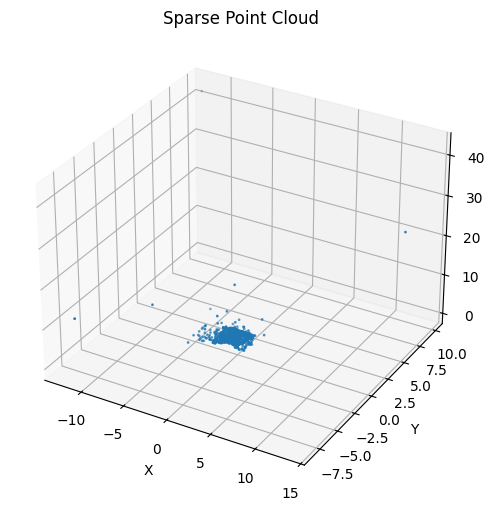

Saved PLY as sfm_output_with_colors.ply


In [ ]:
points3d, colors, cam_R, cam_t, img_paths = incremental_sfm(
    data_dir="/content/drive/MyDrive/Photo/Dataset/New dataset"
)


In [ ]:
from google.colab import files
files.download("sfm_output_with_colors.ply")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>